# Researcher Agent

In [1]:
import os
import sys
import random
import json
from pydantic import BaseModel, Field
from dataclasses import dataclass, field
import plotext
import numpy
from enum import Enum
import asyncio

from typing import Annotated, Literal, Sequence, Union, List, Dict, Tuple, Optional, Any
from typing_extensions import TypedDict

from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, FunctionMessage, \
                                    AIMessage, ToolCall

from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import ToolMessage
from langchain.output_parsers import JsonOutputKeyToolsParser
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

from IPython.display import Image, display

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.utils import set_chatgpt_env, set_langsmith_env, set_tavily_env

## Agent State Reducer

In [2]:
# Define an END constant
class Annotation:
    def __init__(self, reducer, default):
        self.reducer = reducer
        self.default = default

    @classmethod
    def Root(cls, annotations):
        # This inner class will serve as our state container
        class Root:
            def __init__(self):
                # Initialize each field with its default value
                for key, annotation in annotations.items():
                    setattr(self, key, annotation.default())
            
            def update(self, key, value):
                if key in annotations:
                    # Get the annotation definition for this key
                    annotation = annotations[key]
                    current_value = getattr(self, key)
                    # Use the reducer to compute the new value
                    new_value = annotation.reducer(current_value, value)
                    setattr(self, key, new_value)
                else:
                    raise KeyError(f"No annotation defined for key: {key}")

            def __repr__(self):
                # Provide a convenient string representation of the state
                state = {key: getattr(self, key) for key in annotations}
                return f"<AgentState {state}>"
                
        return Root

In [3]:
# Create AgentState similar to the JavaScript version
AgentStateModel = Annotation.Root({
    "messages": Annotation(
        reducer=lambda x, y: x + y,   # Concatenates lists
        default=lambda: []            # Default is an empty list
    ),
    "next": Annotation(
        reducer=lambda x, y: y if y is not None else x if x is not None else END,
        default=lambda: END           # Default value is END
    )
})

# Example usage:
state = AgentStateModel()
print("Initial state:", state)

# Update messages by concatenating a new list
state.update("messages", ["Hello, world!"])
print("After updating messages:", state)

# # Update messages by concatenating a new list
state.update("messages", ["Goodbye, world!"])
print("After updating messages:", state)

# # Update the 'next' value; since a non-None value is provided, it replaces the old one
state.update("next", "Step2")
print("After updating next:", state)

Initial state: <AgentState {'messages': [], 'next': '__end__'}>
After updating messages: <AgentState {'messages': ['Hello, world!'], 'next': '__end__'}>
After updating messages: <AgentState {'messages': ['Hello, world!', 'Goodbye, world!'], 'next': '__end__'}>
After updating next: <AgentState {'messages': ['Hello, world!', 'Goodbye, world!'], 'next': 'Step2'}>


## Utils

In [4]:
class WorkerState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


def build_llm():
    """Build an LLM with a custom model name."""
    return ChatOpenAI(model="gpt-4", temperature=0)


def get_last_message(state) -> BaseMessage:
    """Get the last message from a list of messages."""
    return state["messages"][-1]


def create_agent_node(agent, node_name: str):
    def node(state, config):
        result = agent.invoke(state, config)
        last_message = get_last_message(result)
        content: str = last_message.content
        return {
            "messages": [
                HumanMessage(content=content, name=node_name)
            ]
        }
    return node


def should_continue(state: WorkerState):
    messages = state["messages"]
    ai_message = messages[-1]
    
    # Check if it's an AI message with tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tool"
    return END


set_langsmith_env()
set_chatgpt_env()
set_tavily_env()

## Search Agent

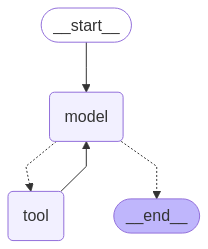

In [5]:
researcher_llm = build_llm()

researcher_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a researcher. Given the conversation below, dig up relevant facts or decide which tool to call."),
    MessagesPlaceholder(variable_name="messages"),
    ("system", "If you choose to call a tool, do so; otherwise, provide your findings in plain text."),
])

# Initialize tools
tavily_tool = TavilySearchResults()
researcher_tools = [tavily_tool]
researcher_tool_node = ToolNode(researcher_tools)

def researcher_model(state: WorkerState) -> WorkerState:
    """Call the model with the current state."""
    messages = state["messages"]
    prompt_messages = researcher_prompt.format_messages(messages=messages)
    result = researcher_llm.bind_tools(researcher_tools).invoke(prompt_messages)
    return {"messages": [result]}


# Create the graph
researcher_graph = (
    StateGraph(WorkerState)
    .add_node("model", researcher_model)
    .add_node("tool", researcher_tool_node)
    .add_edge(START, "model")
    .add_edge("tool", "model")
    .add_conditional_edges(
        "model",
        should_continue,
        {
            "tool": "tool",
            END: END,
        }
    )
)

# Compile the graph
researcher_agent = researcher_graph.compile()

display(Image(researcher_agent.get_graph().draw_mermaid_png()))

## Bar Chart Agent

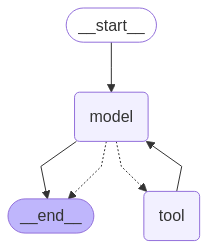

In [ ]:
bar_chart_llm = build_llm()

# Define tool schema
class BarChartInput(BaseModel):
    """Input schema for the bar chart generator."""
    data: Dict[str, float] = Field(..., description="Dictionary where keys are labels and values are numeric values to plot")
    title: str = Field(default="Bar Chart", description="Title of the chart")
    
# Create the tool
@tool(args_schema=BarChartInput)
def generate_bar_chart(data: Dict[str, float], title: str) -> str:
    """Generate a bar chart from data points and display it.
    
    Parameters
    ----------
        data: Dict[str, float]
            Dictionary where keys are labels and values are numeric values to plot
        title: str
            Title of the chart (optional, defaults to "Bar Chart")
        
    Returns:
        plot as string
        
    Example:
        input = BarChartInput(
            data={"A": 10, "B": 20, "C": 15},
            title="Sample Chart"
        )
    """

    cats = list(data.keys())
    vals = list(data.values())
    plotext.clear_figure()
    plotext.bar(cats, vals)
    plotext.title(title)
    
    return plotext.build()

bar_chart_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a chart generator. You may use the generate_bar_chart tool to generate a chart."),
    MessagesPlaceholder(variable_name="messages"),
    ("system", "If you choose to call a tool, do so; otherwise, provide your findings in plain text."),
])

bar_chart_tools = [generate_bar_chart]
bar_chart_tool_node = ToolNode(tools=bar_chart_tools)

# Define agent node with tools
def bar_chart_model(state: WorkerState):
    """Call the agent with the current state."""
    messages = state["messages"]
    prompt_messages = bar_chart_prompt.format_messages(messages=messages)
    result = bar_chart_tool_node.invoke(prompt_messages)
    return {"messages": [result]}


def bar_chart_should_continue(state: WorkerState):
    messages = state["messages"]
    ai_message = messages[-1]

    # Check if it's an AI message with tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tool"
    return END
    
# Create and configure the graph
bar_chart_workflow = StateGraph(WorkerState)
bar_chart_workflow.add_node("model", bar_chart_model)
bar_chart_workflow.add_node("tool", bar_chart_tool_node)

bar_chart_workflow.add_edge(START, "model")
bar_chart_workflow.add_edge("tool", "model")
bar_chart_workflow.add_conditional_edges(
    "model",
    bar_chart_should_continue,
    {
        "tool": "tool",
        END: END
    }
)
bar_chart_workflow.add_edge("model", END)

# Compile the graph
bar_chart_agent = bar_chart_workflow.compile()

display(Image(bar_chart_agent.get_graph().draw_mermaid_png()))

## Supervisor Agent

In [ ]:
team_members = ["researcher", "bar_chart_generator"]
options = [END] + team_members

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the "
    "following workers: {team_members}. Given the following user request, "
    "respond with the worker to act next. Each worker will perform a task "
    "and respond with their results and status. When finished, respond with FINISH."
)

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="messages"),
    (
        "system",
        "Given the conversation above, who should act next? "
        "Or should we FINISH? Select one of: {options}"
    ),
])

formatted_prompt = prompt.partial(
    options=", ".join(options), team_members=", ".join(team_members)
)

# Initialize LLM
supervisor_llm = build_llm()

# Define supervisor
supervisor = formatted_prompt | supervisor_llm

researcher_node = create_agent_node(researcher_agent, "Researcher")
bar_chart_node = create_agent_node(bar_chart_agent, "BarChartGenerator")

worker_map = {
    "researcher": researcher_node,
    "bar_chart_generator": bar_chart_node,
}

async def run_conversation(user_question: str):
    state = AgentStateModel()
    state.update("messages", [HumanMessage(content=user_question)])

    while True:
        agent_msg = {"messages": [HumanMessage(content=user_question)]}

        sup_out = supervisor.invoke(agent_msg)
        next_node = sup_out.content
        state.update("next", next_node)

        nxt = state.next
        if nxt in (END, "FINISH"):
            break

        if nxt not in worker_map:
            raise RuntimeError(f"Unknown worker: {nxt}")

        worker = worker_map[nxt]
        print(state)
        out = worker(agent_msg, {})
        print(out["messages"])
        state.update("messages", out["messages"])

    return state

In [ ]:
final_state = await run_conversation("Tell me the latest news on the stock market?")
for msg in final_state.messages:
    print(f"{msg.name}: {msg.content}")

<AgentState {'messages': [HumanMessage(content='Tell me the latest news on the stock market?', additional_kwargs={}, response_metadata={})], 'next': 'researcher'}>
[HumanMessage(content='The latest news on the stock market indicates a positive trend. The S&P 500 jumped 1.5% on Friday, May 2, 2025, due to a strong pace of hiring in April despite tariff-related uncertainties. The S&P 500 Index has been rising for nine straight sessions, gaining 10% in that time, and has recouped all of its losses since April 2, when President Donald Trump launched his global trade war. Investors in the US technology behemoths that dominate the S&P 500 Index are relieved as last week’s earnings reports from the group show their outlooks remain mostly strong in the face of President Donald Trump’s shifting trade policies. The stock market is also rallying as AI spending and Trump tariff news turn positive. However, oil prices have sunk as OPEC+ hikes output. [Sources: Yahoo Finance, Market Watch, CNN, Reut